In [2]:
import pyscf
import slowquant.SlowQuant as sq
from qiskit_nature.second_q.mappers import JordanWignerMapper
from slowquant.qiskit_interface.interface import QuantumInterface
from slowquant.qiskit_interface.wavefunction import WaveFunction
from slowquant.unitary_coupled_cluster.ups_wavefunction import WaveFunctionUPS
#from slowquant.qiskit_interface.linear_response.projected import quantumLR

from qiskit_ibm_runtime.fake_provider import FakeTorino

from qiskit.primitives import Estimator

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_aer.primitives import Sampler
from qiskit_aer.primitives import SamplerV2

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

import numpy as np
from scipy.optimize import minimize
import itertools
import random
from scipy.optimize import curve_fit
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import csv

In [3]:
mol = pyscf.M(atom="""H 0.0 0.0 0.0;
                      H 1.5 0.0 0.0;
                      H 0.0 1.8 0.0;
                      H 1.5 1.8 0.0;""", basis="sto-3g", unit="angstrom")
rhf = pyscf.scf.RHF(mol).run()

sampler = Estimator()
primitive = sampler
mapper = JordanWignerMapper()
# For H4 you can make the wavefunction better by increasing n_layers.
# n_layers: 3 will prob. give almost the FCI solution.
QI = QuantumInterface(primitive, "tUPS", mapper, ansatz_options={"n_layers": 2, "do_pp": True}, ISA = True)

WF = WaveFunction(
    mol.nao * 2,
    mol.nelectron,
    (4, 4),
    np.load("orbitals.npy"),
    mol.intor("int1e_kin") + mol.intor("int1e_nuc"),
    mol.intor("int2e"),
    QI,
    #include_active_kappa = True
)

#WF.run_vqe_2step("RotoSolve", maxiter=3)
#WF.run_vqe_2step("SLSQP", maxiter=40)
WF.ansatz_parameters = [3.139971979175481, 2.794423289836064, 3.1396666774542217, -3.1279628624838636, -0.3477597864402062, 3.131254822687457, -1.5712922633570714, 0.049457657628517115, 3.1428145974375497, 2.7060354369343496, -0.08622479525081332, 2.7900642540466234, -2.7604987363719484, -0.03332307014761141, -2.7370553249708895, -3.2725379283962637, -0.15194244920006572, 3.2618598820421307]
optimized_parameters = WF.ansatz_parameters
#no noise
nonclif_ground_state_energy = WF.energy_elec
print("Non-Clifford Ground state energy:", nonclif_ground_state_energy)

#device noise
# Update the primitive with simulated noise
backend = FakeTorino()
QI.pass_manager = generate_preset_pass_manager(3,backend=backend,seed_transpiler=123) # seeded standard transpiler
QI.do_postselection = False
QI.do_M_mitigation = False
noise_model = NoiseModel.from_backend(backend)
sampler = Sampler(backend_options={"noise_model":noise_model})
WF.change_primitive(sampler)    
# Calculate the ground state energy using the noisy simulator
noisy_nonclif_ground_state_energy = WF.energy_elec
print("Noisy Non-Clifford Ground state energy:",noisy_nonclif_ground_state_energy)

converged SCF energy = -1.77674731624872
Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None with optimization level 3
Non-Clifford Ground state energy: -3.71220912593985


/var/folders/wh/h8p20wfx6_gb62mc1gww1sm40000gn/T/ipykernel_1782/3829062842.py:7: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  sampler = Estimator()


Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [17, 25, 35, 24, 28, 26, 27, 44]
 Non-local gates:     270
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['cz', 'sx', 'x', 'measure', 'id', 'reset']>)

Noisy Non-Clifford Ground state energy: -3.1032268805352565


In [4]:
import csv

def read_from_csv(filename):
    linear_results, nonlinear_results = [], []
    with open(filename, mode='r') as file:
        reader = csv.reader(file)
        next(reader)
        for row in reader:
            key, value = row[0], eval(row[1])
            if key == "Linear":
                linear_results.append(value)
            elif key == "Nonlinear":
                nonlinear_results.append(value)
    return linear_results, nonlinear_results

def transpose_results(results):
    transposed = [list(row) for row in zip(*results)]
    return transposed

linear_results, nonlinear_results = read_from_csv("k scan 2layer.csv")

linear_results_transposed = transpose_results(linear_results)
nonlinear_results_transposed = transpose_results(nonlinear_results)

linear_results, nonlinear_results = read_from_csv("k scan 2layer zero.csv")

linear_results_zero = transpose_results(linear_results)
nonlinear_results_zero = transpose_results(nonlinear_results)



In [5]:
avg_linear = []
avg_nonlinear = []
avg_zero = []
avg_nonzero= []
std_zero = []
std_nonzero= []
std_linear = []
std_nonlinear = []
delta_zero = []
delta_nonzero = []
delta_linear = []
delta_nonlinear = []

for i in range(len(linear_results_transposed)):
    linear_average = np.mean(linear_results_transposed[i])
    linear_std = np.std(linear_results_transposed[i])
    linear_delta = np.abs(nonclif_ground_state_energy - linear_average)
    std_linear.append(linear_std)
    avg_linear.append(linear_average)
    delta_linear.append(linear_delta)

for i in range(len(nonlinear_results_transposed)):
    nonlinear_average = np.mean(nonlinear_results_transposed[i])
    nonlinear_std = np.std(nonlinear_results_transposed[i])
    nonlinear_delta = np.abs(nonclif_ground_state_energy - nonlinear_average)
    avg_nonlinear.append(nonlinear_average)
    std_nonlinear.append(nonlinear_std)
    delta_nonlinear.append(nonlinear_delta)

for i in range(len(linear_results_zero)):
    zero_average = np.mean(linear_results_zero[i])
    zero_std = np.std(linear_results_transposed[i])
    zero_delta = np.abs(nonclif_ground_state_energy - zero_average)
    delta_zero.append(zero_delta)
    avg_zero.append(zero_average)
    std_zero.append(zero_std)

for i in range(len(nonlinear_results_zero)):
    nonzero_average = np.mean(nonlinear_results_zero[i])
    nonzero_std = np.std(linear_results_transposed[i])
    nonzero_delta = np.abs(nonclif_ground_state_energy - nonzero_average)
    delta_nonzero.append(nonzero_delta)
    avg_nonzero.append(nonzero_average)
    std_nonzero.append(nonzero_std)
    

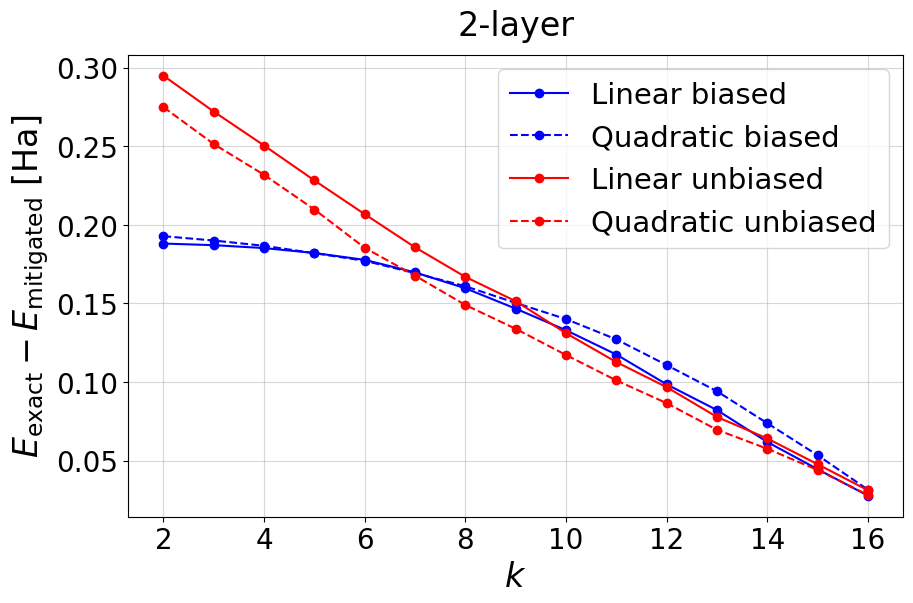

In [ ]:
x_linear = np.arange(2, 17)
x_others = np.arange(2, 17)

plt.figure(figsize=(10, 6))
plt.plot(x_linear, delta_linear, label='Linear biased', linestyle='-', color='b', marker = 'o')
plt.plot(x_others, delta_nonlinear, label='Quadratic biased', linestyle='--', color='b', marker = 'o')
plt.plot(x_linear, delta_zero, label='Linear unbiased', linestyle='-', color='r', marker = 'o')
plt.plot(x_others, delta_nonzero, label='Quadratic unbiased', linestyle='--', color='r', marker = 'o')
#plt.plot(x_linear, noisy, label="noisy value")

#plt.ylim(0.17, 0.225)
plt.title('2-layer', fontsize=24, pad=14)
#plt.title('Absolute Energy Error', fontsize=16)
plt.xlabel(r'$k$', fontsize=24)
plt.ylabel(r'$E_{\mathrm{exact}} - E_{\mathrm{mitigated}}\ [\mathrm{Ha}]$', fontsize=24)
plt.legend(fontsize=21)
plt.grid(alpha=0.5)
plt.xticks(fontsize=20) 
plt.yticks(fontsize=20)

#plt.tight_layout()
plt.show()